# **Face Recognition Using PCA & LDA**


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Generate the Data Matrix and the Label vector


In [3]:
paths = ["datasets/s" + str(i) for i in range(1, 41)]
cnt = 0
Data = np.zeros((400, 10304))
labels = np.zeros((400, 1))
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt] = np_img
        cnt += 1

### Data Visualization


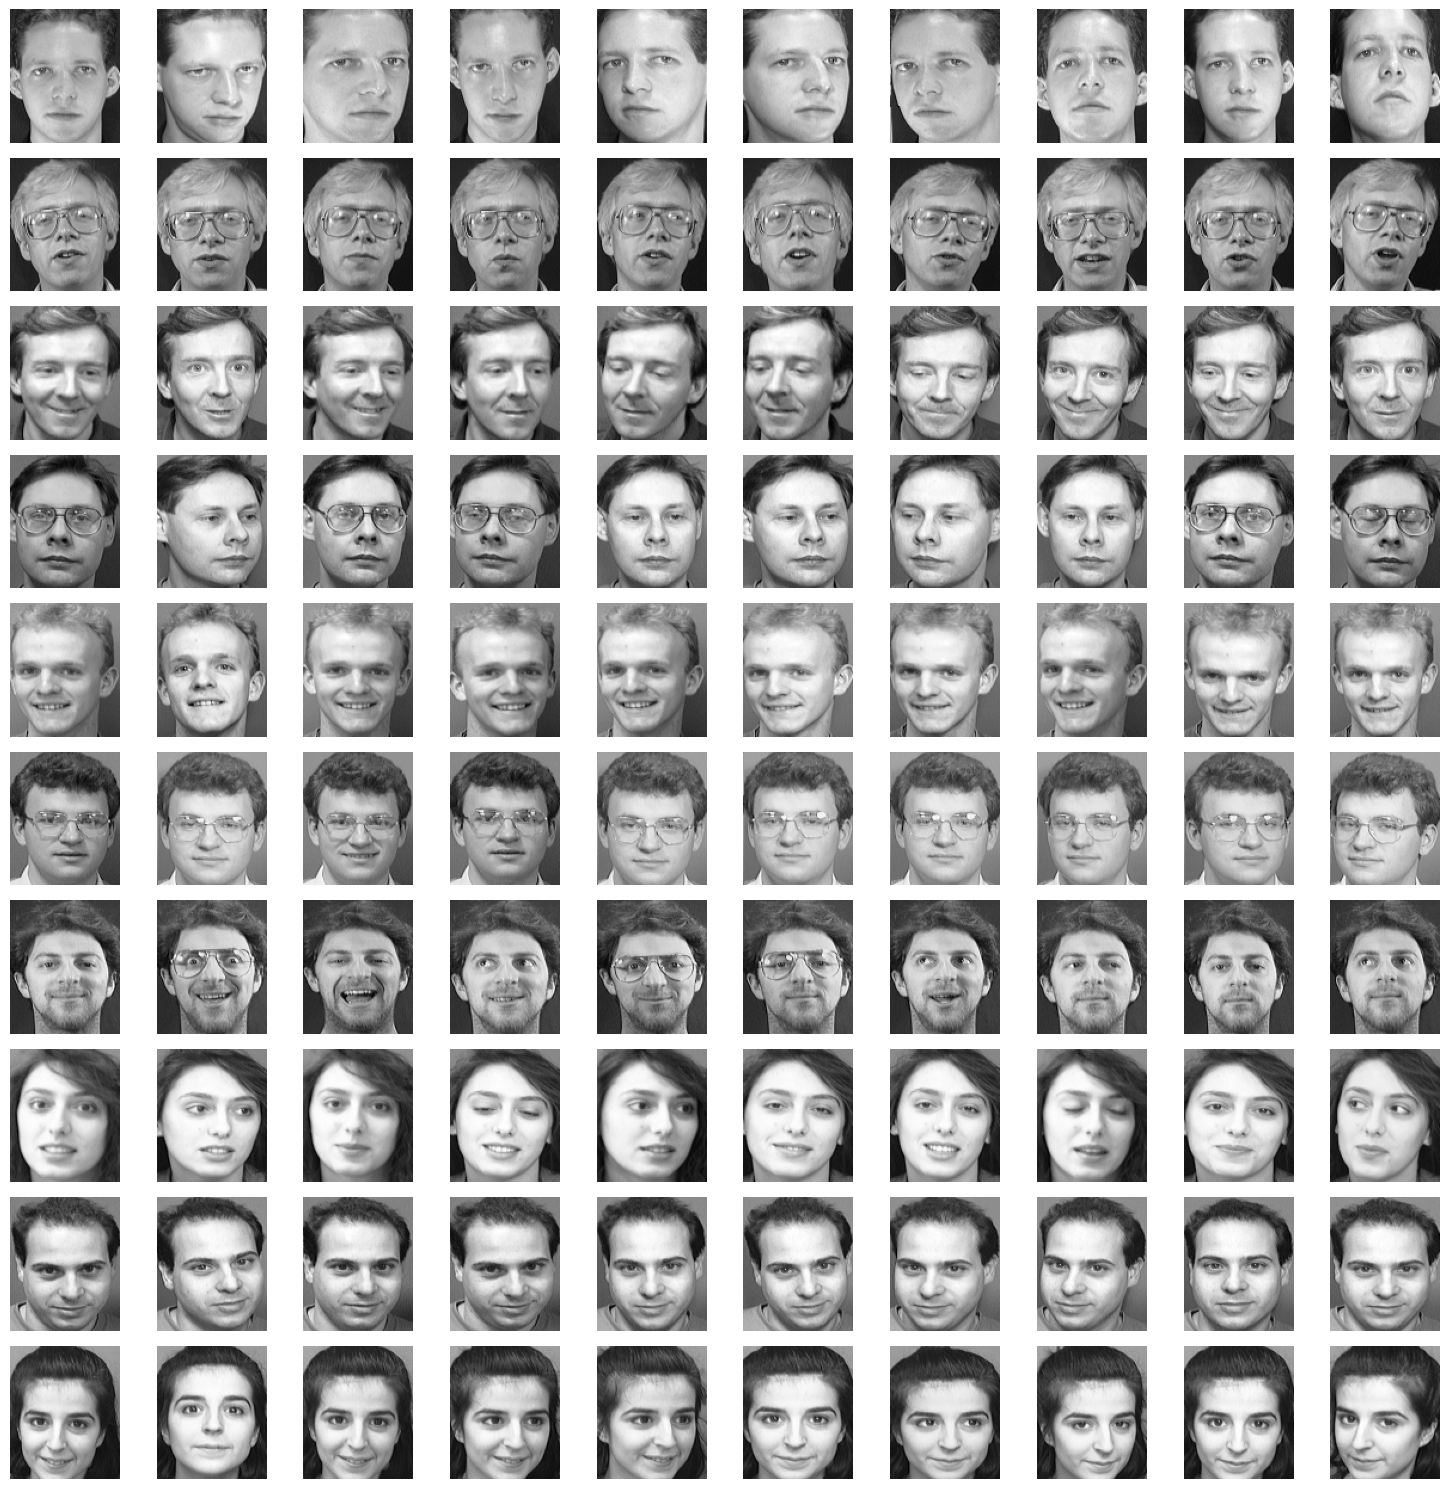

In [3]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(10, 10, figsize=(15, 15))  # Create a grid of 2x2 subplots

# Flatten the array of axes
axs = axs.ravel()

for i in range(100):  # Change this to plot more/fewer images
    image_array = np.reshape(Data[i], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")  # Use cmap='gray' for grayscale images
    axs[i].axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

## Splitting The Dataset


In [111]:
X_train = Data[0::2]
X_test = Data[1::2]
y_train = labels[0::2]
y_test = labels[1::2]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


## PCA


In [112]:
def get_PCA(X_train, alpha):
    # Compute the mean of the training data
    mean_face = np.mean(X_train, axis=0)
    # subtract the mean from the training data
    X_train_centralized = X_train - mean_face
    # compute the covariance matrix
    cov_matrix = X_train_centralized @ X_train_centralized.T
    cov_matrix /= X_train_centralized.shape[1]
    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # restore the original eigenvectors
    eigenfaces = X_train_centralized.T @ eigenvectors
    sum = 0
    no_components = 0
    for i in range(len(eigenvalues)):
        sum += eigenvalues[i]
        no_components += 1
        if sum / np.sum(eigenvalues) >= alpha:
            break

    # project the training data on the eigenfaces
    X_train_pca = X_train_centralized @ eigenfaces[:, :no_components]
    return X_train_pca, mean_face, eigenfaces[:, :no_components]

In [113]:
def Test_PCA(alpha, k):
    X_train_pca, mean_face, eigenfaces = get_PCA(X_train, alpha)
    X_test_centralized = X_test - mean_face
    X_test_pca = X_test_centralized @ eigenfaces
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train_pca, y_train.ravel())
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy


print("PCA Accuracy: " + str(Test_PCA(0.95, 1)))

PCA Accuracy: 0.925


## Classifier Tuning for PCA


In [114]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
df = pd.DataFrame(index=alphas, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        accuracy = Test_PCA(num_dominant_eigen_vectors, k)
        df.loc[num_dominant_eigen_vectors, k] = accuracy

df

,1,3,5,7,9
0.80,0.925,0.785,0.685,0.605,0.59
0.85,0.925,0.785,0.69,0.625,0.59
0.90,0.925,0.78,0.69,0.625,0.59
0.95,0.925,0.775,0.69,0.62,0.59


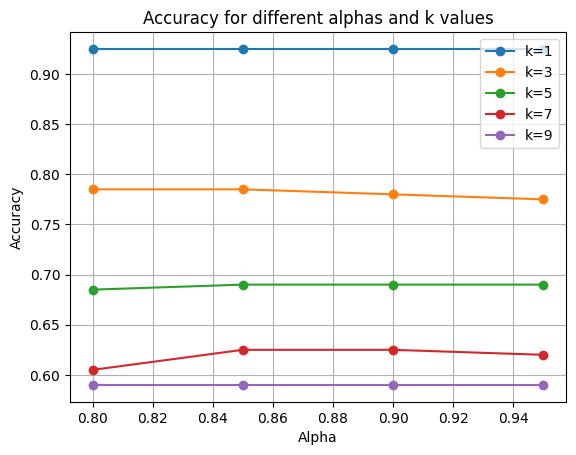

In [115]:
for k in k_values:
    plt.plot(df.index, df[k], marker="o", label=f"k={k}")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy for different alphas and k values")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# LDA


In [116]:
def LDA_Eigen(num_classes, instances_per_class, X_train):

    # getting overall mean
    overall_mean = np.mean(X_train, axis=0)
    overall_mean = overall_mean.reshape(10304, 1)

    # splitting data into classes
    classes_data = []
    count = 0
    for i in range(num_classes):
        d = X_train[count : count + instances_per_class[i]]
        classes_data.append(d)
        # print(classes_data)
        count += instances_per_class[i]

    # calculate mean for every class of the 40 class
    # classes mean array of means 10304 x 1
    classes_means = []

    for i in range(num_classes):
        mean = np.mean(classes_data[i], axis=0)
        classes_means.append(mean.reshape(10304, 1))

    # getting Sb matrix 10304 x 10304
    S_B = np.zeros((10304, 10304))
    for i in range(num_classes):
        difference = classes_means[i] - overall_mean
        S_B = np.add(
            S_B,
            np.dot(
                instances_per_class[i], np.dot(difference, np.transpose(difference))
            ),
        )

    S_W = np.zeros((10304, 10304))
    for i in range(num_classes):
        z = classes_data[i] - np.transpose(classes_means[i])
        # Summing up the scatter matrix for each class
        S_W = np.add(S_W, np.dot(np.transpose(z), z))

    # compute eigen values and eigen vectors
    S_inverse = np.linalg.inv(S_W)
    eigen_values, eigen_vectors = np.linalg.eigh(np.dot(S_inverse, S_B))
    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]

    # return the eigen values and eigen vectors
    return eigen_values, eigen_vectors

In [117]:
def LDA_Projected(
    X_train, X_test, eigen_values, eigen_vectors, num_dominant_eigen_vectors
):
    index = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[index]
    eigen_vectors = eigen_vectors[:, index]

    # projection matrix
    projection_matrix = eigen_vectors[:, :num_dominant_eigen_vectors]
    # data after projection
    projected_X_train = np.dot(X_train, projection_matrix)
    projected_X_test = np.dot(X_test, projection_matrix)

    return projected_X_train, projected_X_test

In [118]:
def get_LDA(instances_per_class, X_train, X_test, num_dominant_eigen_vectors):
    eigen_values, eigen_vectors = LDA_Eigen(40, instances_per_class, X_train)
    projected_X_train, projected_X_test = LDA_Projected(
        X_train, X_test, eigen_values, eigen_vectors, num_dominant_eigen_vectors
    )
    return projected_X_train, projected_X_test


instances_per_class = np.full(40, 5)
projected_X_train, projected_X_test = get_LDA(instances_per_class, X_train, X_test, 39)
print(projected_X_train.shape)
print(projected_X_test.shape)

(200, 39)
(200, 39)


## Classifier Tuning for LDA


In [119]:
k_values = [1, 3, 5, 7, 9]

# Initialize a list to store the results
results = []

# Loop over the values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(projected_X_train, y_train.ravel())
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    results.append({"accuracy": accuracy})

# Convert the results to a DataFrame
df = pd.DataFrame(results, index=k_values)
df.index.name = "k"
df

,accuracy
k,
1,0.955
3,0.855
5,0.765
7,0.725
9,0.700


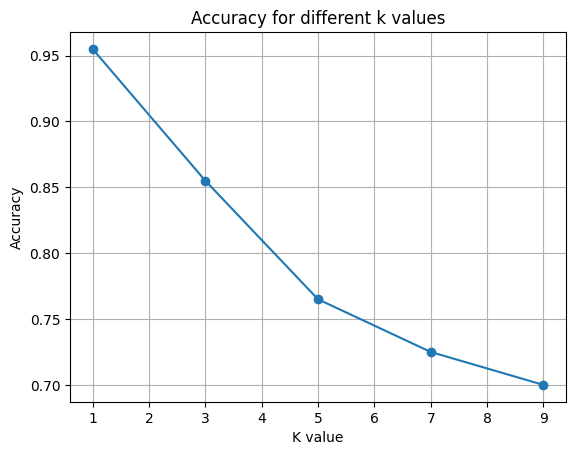

In [120]:
plt.plot(df, marker="o")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.grid(True)
plt.show()

## Variant of PCA


## Variant of LDA
